# WATERSHED DELINEATION

Useful Definitions: 
- Watershed ~ A watershed is then all the surrounding land area that drains to a point in a river/stream/lake. i.e. if you put a drop of water anywhere in a watershed, the water will eventually reach the selected point. 
- Stream gage ~  A stream gage is a measurement station within a stream 

This code delineates the watershed for a stream gage in Rochester MN using elevation data. Most of the code that follows is based on the quickstart and documentation for the pysheds module, linked as follows: https://github.com/mdbartos/pysheds

### Import modules
nb: All !pip install lines have been commented out. If you need to install any of the modules below, please uncomment the lines

In [2]:
import numpy as np
#!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#!pip install pysheds
from pysheds.grid import Grid

#!pip install rasterio
import rasterio
import rasterio.mask
from rasterio import features

#!pip install seaborn
import seaborn as sns
import warnings

import shapely
from shapely.geometry import Point, Polygon, MultiPoint, shape
from shapely.geometry.multipolygon import MultiPolygon

import pandas as pd
from pyproj import CRS

#!pip install openpyxl
import openpyxl

import seaborn as sns

### Define outlet point
The outlet point is the location of the stream gage

In [3]:
lat,lon = -92.46628890, 44.06163100 # WGS 1984
x,y = 542744.39, 4878871.65 # UTM Zone 15 N

### Import and Clip DEM data

In [4]:
# Define polygon for clipping the DEM data
buff_dist = 45000 # buffer distance
clip_boundary = Polygon([[x-buff_dist,y+buff_dist],[x+buff_dist,y+buff_dist],
                  [x+buff_dist,y-buff_dist],[x-buff_dist,y-buff_dist]]) # clipping boundary as a polygon
clip_boundary_multi = MultiPolygon([clip_boundary])

This code will use the MN 30 m DEM data found here: 

In [5]:
# Import MN 30 m resolution DEM data, clip to the clipping boundary, and export as a new tif file

with rasterio.open('digital_elevation_model_30m_15N_2.tif') as src: # open up the DEM
    out_image, out_transform=rasterio.mask.mask(src,[clip_boundary_multi],nodata=-9999,crop=True) # clip the data
    
    # write a new tif file
    out_meta=src.meta
    out_meta.update(
        {
            "driver":"GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform":out_transform,
        }
    )
    with rasterio.open('clipped_raster.tif',"w",**out_meta) as dest:
        dest.write(out_image)

# sources: 
# - https://stackoverflow.com/questions/66008608/how-to-cut-our-raster-with-bigger-buffer
# - https://stackoverflow.com/questions/65124253/polygon-object-is-not-iterable-ipython-cookbook

In [6]:
# import clipped tiff file and print useful information

grid = Grid.from_raster('clipped_raster.tif',data_name='dem')
my_crs = grid.dem.crs.srs
print('No data value:',grid.nodata)
print('Coordinate Reference: ',my_crs)

No data value: -9999
Coordinate Reference:  +proj=utm +zone=15 +datum=NAD83 +units=m +no_defs


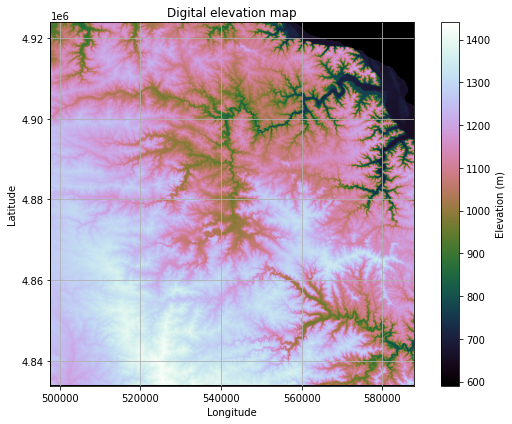

In [7]:
# commentary -> setting no date = -9999 is a mistake 
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1,vmin=590)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [8]:
grid.fill_depressions(data='dem', out_name='flooded_dem')
grid.resolve_flats('flooded_dem', out_name='inflated_dem')

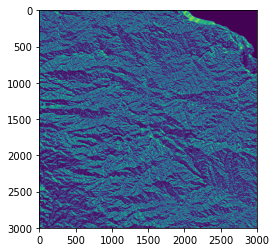

In [9]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# maybe need to specify projection
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
#dir = grid.view('dir')
plt.imshow(grid.dir)

In [10]:
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

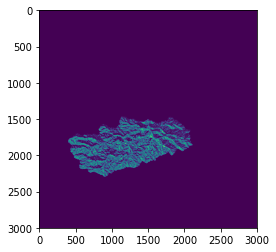

In [11]:
catch = grid.view('catch')
plt.imshow(catch)

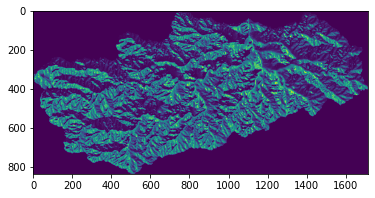

In [12]:
# zoomed in to catchment
grid.clip_to('catch')
plt.imshow(grid.view('catch'))

In [13]:
# catchment to tiff
grid.to_raster('catch','rochester_catchment_raster.tif')

In [14]:
# import and re-project

import rasterio.warp

my_poly_json = []
my_poly_shapely = []

with rasterio.open('rochester_catchment_raster.tif') as r: 
    
    mask_r = r.read_masks(1)

    for geom, val in rasterio.features.shapes(
        mask_r,mask=mask_r,transform=r.transform):
        
        geom = rasterio.warp.transform_geom(
            r.crs, 'EPSG:4326', geom, precision=6)
    #    my_poly.append(shape(geom))
    
    
        my_poly_json.append(geom)
        my_poly_shapely.append(shape(geom))
        
my_poly_shapely = MultiPolygon(my_poly_shapely)
        
#all_poly = MultiPolygon(my_poly)
# sources: 
# - https://rasterio.readthedocs.io/en/latest/
# - https://rocreguant.com/convert-a-mask-into-a-polygon-for-images-using-shapely-and-rasterio/1786/

In [15]:
# process polygons

# get just the boundaries
# areas = [i.area for i in my_poly_shapely]
# max_area_idx = areas.index(max(areas))

# watershed_poly = my_poly_json[max_area_idx]
# removes middle polygon - the edge polygons must be four separate 
# maybe need to get better at mask

from shapely.geometry import mapping

boundary_coords = my_poly_json[1]["coordinates"][0]

no_holes = MultiPolygon(Polygon(p.exterior) for p in my_poly_shapely)
no_holes = mapping(no_holes)
# source: 
# - https://stackoverflow.com/questions/48082553/convert-multipolygon-to-polygon-in-python
# - https://gis.stackexchange.com/questions/166934/python-library-for-converting-geojson-multi-polygon-to-polygon

In [62]:
import folium

attr_str ='Tiles courtesy of the <a href="https://usgs.gov/">U.S. Geological Survey</a>'

m = folium.Map([43.9215049,-92.5311736], zoom_start=10,
               tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',attr=attr_str)

# for geom in my_poly_json: 
#     folium.GeoJson(geom).add_to(m)
    
folium.GeoJson(no_holes).add_to(m)    
folium.Marker([lon,lat],popup='Stream Gage Location').add_to(m)

#folium.GeoJson(watershed_poly).add_to(m)
m
              
# sources: 
# - Lab 7 geocomp
# - https://stackoverflow.com/questions/58305337/plotting-polygons-in-python-using-geopandas-and-folium
# - not plotting because of projection issue (https://gis.stackexchange.com/questions/367200/folium-geojson-displays-all-polygons-in-geodataframe-but-not-individual-ones)


Debugging notes: 
- doesn's seem to be related to no data value
- module does NOT like working in WGS 1984

# LAND USE

In [17]:
# pre-processed land cover that intersects with catchment in ArcGIS Pro

# read in data
with rasterio.open('NLCD_2016_masked.tif') as src:
    band1 = src.read(1)
    band1_agg = band1.flatten()
    print(band1_agg)

[0 0 0 ... 0 0 0]


In [18]:
# metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/biota_landcover_nlcd_mn_2016/metadata/metadata.html
land_cover = np.asarray(band1_agg)
land_cover = pd.DataFrame(data=land_cover,columns=['Number'])
lc_filtered = land_cover[land_cover['Number']>0]

legend = pd.read_excel(r'NLCD_legend.xlsx')

lc_all = lc_filtered.merge(legend,on='Number')
print(lc_all)

# sources: 
# - https://www.kite.com/python/answers/how-to-create-pandas-dataframe-from-a-numpy-array-in-python
# - https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/

        Number              Name
0           82  Cultivated Crops
1           82  Cultivated Crops
2           82  Cultivated Crops
3           82  Cultivated Crops
4           82  Cultivated Crops
...        ...               ...
854598      52       Shrub/Scrub
854599      52       Shrub/Scrub
854600      52       Shrub/Scrub
854601      52       Shrub/Scrub
854602      52       Shrub/Scrub

[854603 rows x 2 columns]


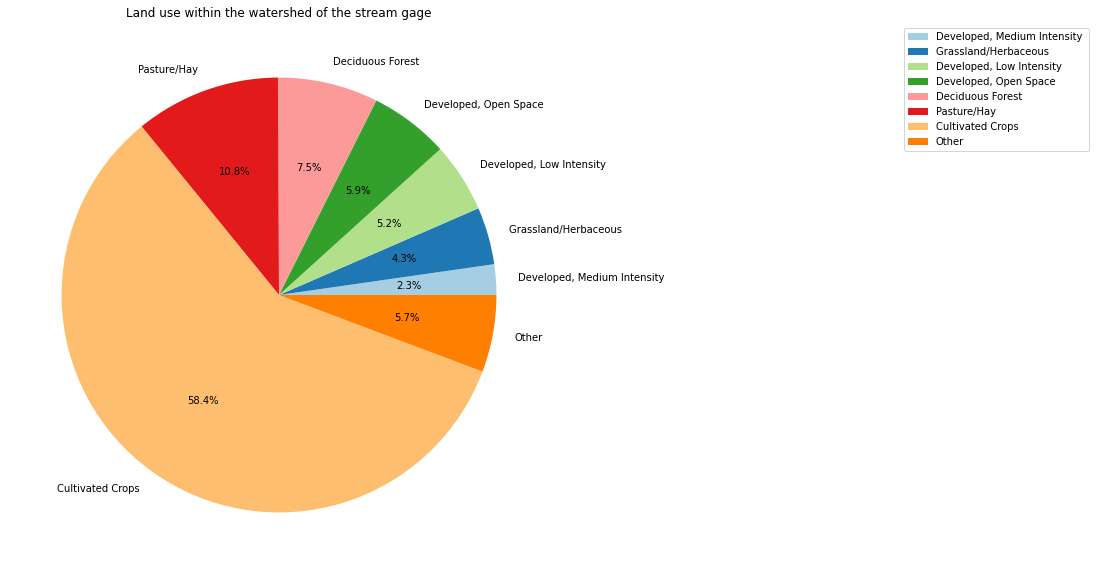

In [46]:
lc_grp = lc_all.groupby('Name').size().reset_index(name='Counts')
lc_grp = lc_grp.sort_values(by=['Counts'])

threshold = 14000
TF = lc_grp['Counts'] < threshold

other_sum = sum(lc_grp.loc[TF,'Counts'])

lc_grp_new = lc_grp[lc_grp['Counts']>threshold]
lc_grp_new.loc[lc_grp_new.size+3] = ['Other', other_sum]

color = sns.color_palette('Paired',lc_grp_new.size)

lc_grp_new['Counts'].plot(kind='pie',figsize=(15,10),colors=color,labels=lc_grp_new.Name,autopct='%1.1f%%',ylabel='')

plt.legend(loc="upper right",bbox_to_anchor=(2,1))
plt.title('Land use within the watershed of the stream gage')
plt.show()

# sources: 
# - https://stackoverflow.com/questions/63687789/how-do-i-create-a-pie-chart-using-categorical-data-in-matplotlib
# - https://www.statology.org/seaborn-pie-chart/    
# - https://www.kite.com/python/answers/how-to-move-the-legend-outside-of-a-matplotlib-plot-in-python
# - https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby